*Sweatpy* has built-in classes and functions for power duration modelling.

## Power duration model fitting

Sweatpy has a `PowerDurationRegressor` class that helps you fit power data to a power duration model ("pdm").
The supported models are:

- 2 parameter pdm. Parameters: CP and W'.
- 3 parameter pdm. Parameters: CP, W' and P<sub>max</sub>.

The `PowerDurationRegressor` follows the [sklearn API guidelines](https://scikit-learn.org/stable/developers/develop.html) for estimators/regressors to provide a familiar interface for data scientists.

Usage:

In [1]:
import sweat

durations = [5, 60, 300, 1200] # Durations in seconds
power = [1300, 600, 330, 290]
# Like all sklearn estimators, the regressor expects a 2 dimensional array of features
X = sweat.array_1d_to_2d(durations)
y = power

pdmreg = sweat.PowerDurationRegressor()  # By default the 2 parameter model is used
pdmreg.fit(X, y);

The fitted parametes are then available as attributes on the regressor:

In [2]:
print(f"CP: {pdmreg.cp_}")
print(f"W': {pdmreg.w_prime_}")

CP: 370.2118107361753
W': 4705.597395915472


To predict power for specific durations using the fitted model:

In [3]:
# Again, the regressor expects a 2 dimensional array of features.
X = sweat.array_1d_to_2d([30, 600, 3600])

print(f"Predicted power values: {pdmreg.predict(X)}")

Predicted power values: [527.06505727 378.05447306 371.51892112]


3 parameter model usage:

In [4]:
import sweat

# Durations in seconds
durations = [5., 60., 300., 1200.]
power = [1300., 600., 330., 290.]

# Like all sklearn estimators, the regressor expects a 2 dimensional array of features.
X = sweat.array_1d_to_2d(durations)


y = power

pdmreg = sweat.PowerDurationRegressor(model="3 param")
pdmreg.fit(X, y)

print(f"CP: {pdmreg.cp_}")
print(f"W': {pdmreg.w_prime_}")
print(f"P_max: {pdmreg.p_max_}")

# Durations in seconds
durations = [30, 600, 3600]
# Again, the regressor expects a 2 dimensional array of features.
X = sweat.array_1d_to_2d(durations)

print(f"Predicted power values: {pdmreg.predict(X)}")

CP: 257.3956711062305
W': 27622.25611757151
P_max: 1542.9905901539807
Predicted power values: [793.89629791 301.84117329 265.02299766]


## W'<sub>balance</sub>

When the model coefficients `CP` and `W'` of the 2 parameter cp model (see above) are known, you can model the W'<sub>balance</sub>.

Usage:

In [5]:
import pandas as pd
import sweat

# First create an artificial workout
artificial_power = 60*[100] + 60*[400] + 30*[100] + 60*[400] + 60*[100]
datetime = pd.to_datetime(list(range(len(artificial_power))), unit="s")
data = pd.DataFrame(dict(power=artificial_power), index=datetime)

# Define the model coefficients
cp = 300
w_prime = 20000

data["W'balance"] = sweat.w_prime_balance(data["power"], cp=cp, w_prime=w_prime).to_list()

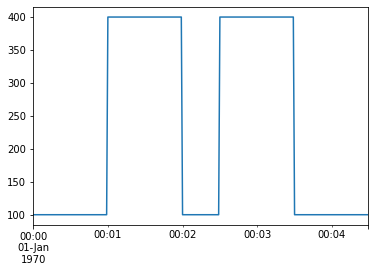

In [6]:
data["power"].plot();

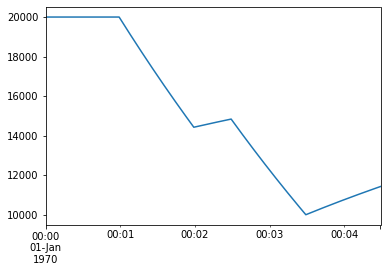

In [7]:
data["W'balance"].plot();

By default, the Waterworth implementation of the Skiba algorithm is used. The list of available algorithms is:

- waterworth
- skiba
- froncioni-skiba-clarke

For a comparison of W'<sub>balance</sub> algorithms, read [this blog post](https://gssns.io/posts/comparison-of-wbalance-algorithms.html).

To use a different algorithm than the default, pass the name of the algorithm to the `sweat.w_prime_balance()` function.

Usage:

In [8]:
sweat.w_prime_balance(
    power=data["power"],
    cp=cp,
    w_prime=w_prime,
    algorithm="froncioni-skiba-clarke")

0      20000.000000
1      20000.000000
2      20000.000000
3      20000.000000
4      20000.000000
           ...     
265    14054.387452
266    14113.843578
267    14172.705142
268    14230.978090
269    14288.668310
Length: 270, dtype: float64

## Comparison of power duration models

Sweatpy has implementations for these power duration models:

- 2 parameter
- 3 parameter
- Exponential
- Omni

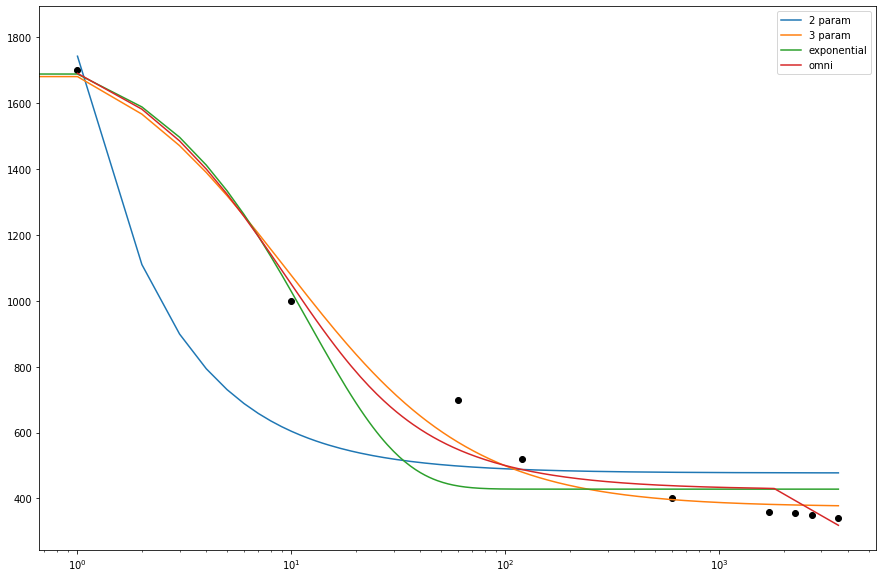

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import sweat

x = [1, 10, 60, 120, 600, 1700, 2250, 2700, 3600]
X = sweat.array_1d_to_2d(x) 
y = [1700, 1000, 700, 520, 400, 360, 355, 350, 340]

two_param = sweat.PowerDurationRegressor(model="2 param")
two_param.fit(X, y)

three_param = sweat.PowerDurationRegressor(model="3 param")
three_param.fit(X, y)

exponential = sweat.PowerDurationRegressor(model="exponential")
exponential.fit(X, y)

omni = sweat.PowerDurationRegressor(model="omni")
omni.fit(X, y)

durations = range(0, 3600)
durations_2d = sweat.array_1d_to_2d(durations)
data = pd.DataFrame({
    "2 param": two_param.predict(durations_2d),
    "3 param": three_param.predict(durations_2d),
    "exponential": exponential.predict(durations_2d),
    "omni": omni.predict(durations_2d),               
})

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_xscale('log')

plt.scatter(x, y, color="black")
for model in ["2 param", "3 param", "exponential", "omni"]:
    plt.plot(durations, data[model], label=model)

ax.legend();